In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import dataframe_image as dfi

### Примеры входных данных

In [3]:
# пример кода для запуска генератора данных
from data_generator.data_generator import generate_data

N = 5
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
seed = 19
data = generate_data(N, bounds_params, grid_size, seed)

In [4]:
# Пример данных для NLP постановки
# plu_line - код продуктовой линейки
# plu - код товара
# plu_idx - индекс товара
# P - текущая цена
# Q - текущие продажи в штуках
# E - эластичность
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# x_lower - нижняя граница x для диапазона поиска цены
# x_upper - верхняя граница x для диапазона поиска цены
# x_init - начальное значение x для старта оптимизатора
# fixed - метка, необходимо ли фиксировать x_init цену на товар, по умолчанию всегда 0
data['data_nlp']
dfi.export(data['data_nlp'], './images/data_nlp_sample.png')

[0727/170348.505317:INFO:headless_shell.cc(660)] Written to file /var/folders/bn/zpkz54h12h91dlsrft_4kvp40000gn/T/tmppk48899h/temp.png.


In [5]:
# Пример данных для MILP постановки
# plu_line - код продуктовой линейки
# P - текущая цена
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# Ps - сетка цен для поиска
# Qs - сетка продаж для кажой цены из Ps
# xs - сетка индексов
# grid_size - размер сетки
# P_idx - индекс текущей цены в сетке. Если значение -1, то текщая цена не попала в сетку
data['data_milp']
dfi.export(data['data_milp'], './images/data_milp_sample.png')

[0727/170349.756988:INFO:headless_shell.cc(660)] Written to file /var/folders/bn/zpkz54h12h91dlsrft_4kvp40000gn/T/tmpl23zfw1a/temp.png.
[0727/170351.014770:INFO:headless_shell.cc(660)] Written to file /var/folders/bn/zpkz54h12h91dlsrft_4kvp40000gn/T/tmp49bezvp8/temp.png.


### Отчет по времени работы и количеству "успешно" решенных задач

In [6]:
from runner import optimizers_collect_stat

In [7]:
stats_df = optimizers_collect_stat('./data/stat/')

In [8]:
stats_df['success'] = stats_df['status'] == 'ok'
stats_df['problem_type'] = np.where(
    stats_df['solver'].isin(['slsqp', 'trust-constr', 'ipopt']), 'nlp', 'lp'
)
time_rep_df = stats_df.groupby(['problem_type', 'solver', 'N'])['t'].describe().reset_index()


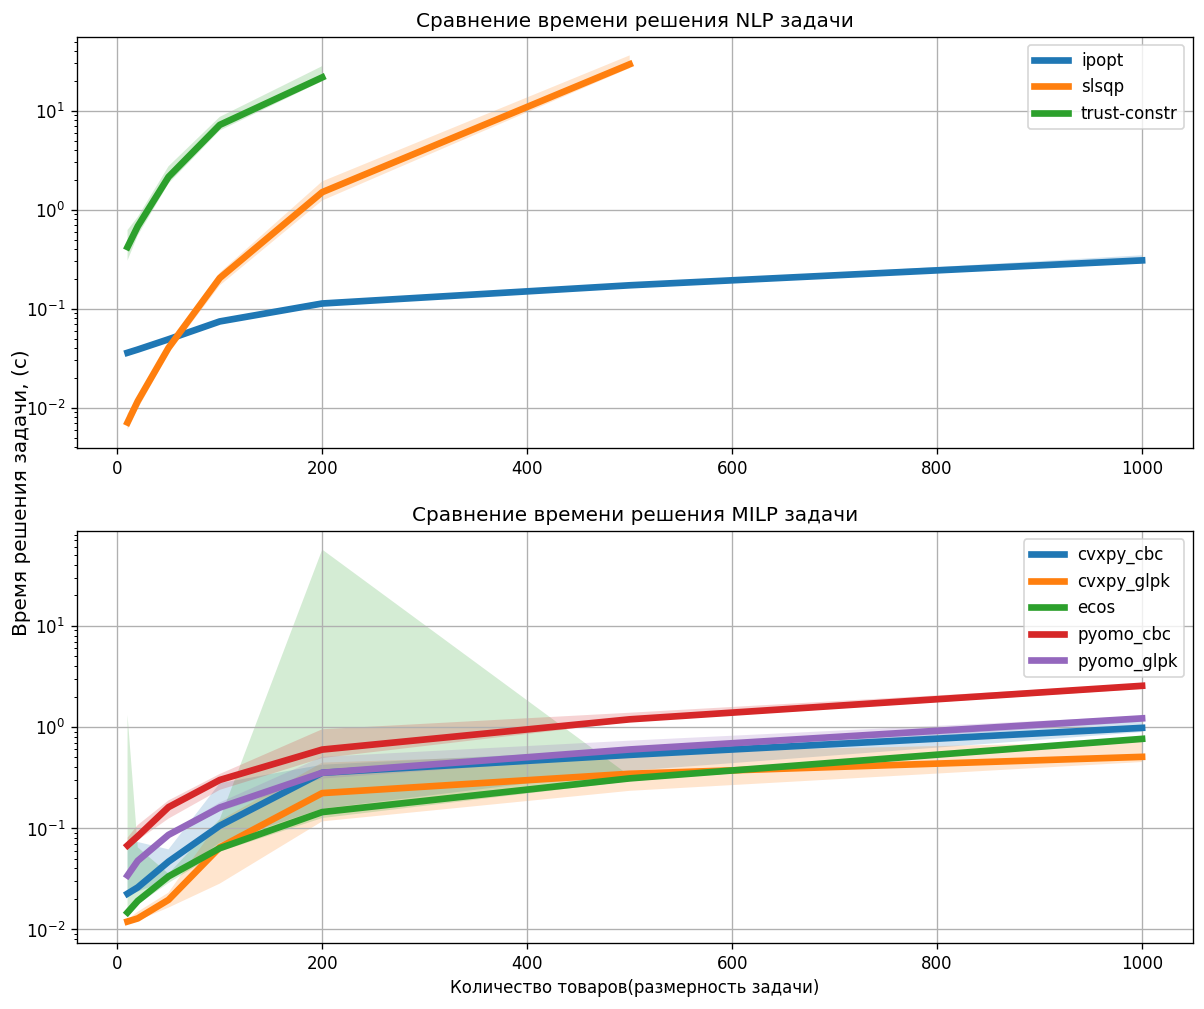

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False, dpi=120)
for (pr_type, solver), df in time_rep_df.groupby(['problem_type', 'solver']):
    ax_id = 0 if pr_type == 'nlp' else 1
    axes[ax_id].plot(df['N'], df['50%'], lw=4, label=solver)
    axes[ax_id].fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
axes[0].set_title('Сравнение времени решения NLP задачи')
axes[1].set_title('Сравнение времени решения MILP задачи')
# [ax.set_xscale('log') for ax in axes]
[ax.set_yscale('log') for ax in axes]
[ax.legend(loc='upper right') for ax in axes]
[ax.grid() for ax in axes]
fig.text(0.08, 0.5, 'Время решения задачи, (с)', va='center', rotation='vertical', fontdict={'size': 12})
plt.xlabel('Количество товаров(размерность задачи)')
# plt.savefig('./images/time_solve_compare.png')
plt.show()


In [10]:
stats_df.groupby(['solver'])['success'].mean().reset_index().rename(columns={'success': 'success_rate'})


,solver,success_rate
0,cvxpy_cbc,1.00
1,cvxpy_glpk,1.00
2,ecos,0.76
3,ipopt,1.00
4,pyomo_cbc,1.00
5,pyomo_glpk,1.00
6,slsqp,1.00
7,trust-constr,0.96


### Пример запуска оптимизации

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)

In [12]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21

data = generate_data(100, bounds_params, 21, 4)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
#     'con_mrg': M_cur,
    'con_equal': True
}

opt_params['alpha'] = 0.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_min = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

opt_params['alpha'] = 1.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_max = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

N_grid = 30
M_grid = np.linspace(M_opt_min, M_opt_max, N_grid)
R_res = np.zeros(N_grid)
M_res = np.zeros(N_grid)

opt_params['alpha'] = 0.0
for i, M in enumerate(M_grid):
    opt_params['con_mrg'] = M
    res, t = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    R_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt'])
    M_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt'])
    

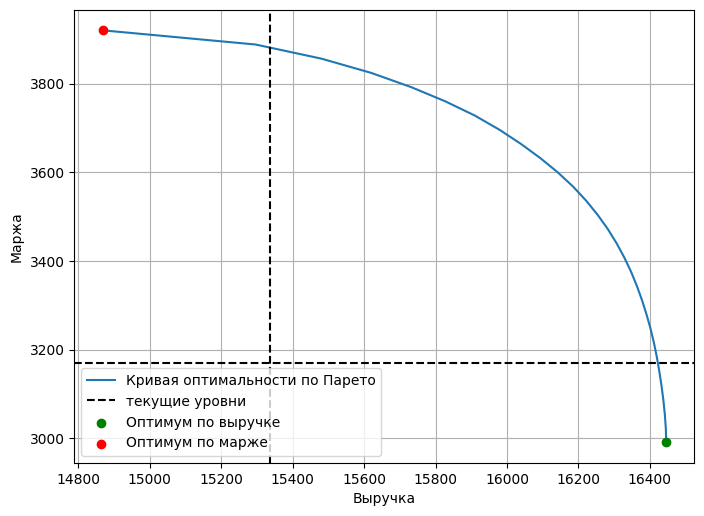

In [13]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_res, M_res, label='Кривая оптимальности по Парето')
plt.axvline(R_cur, ls='--', c='k', label='текущие уровни')
plt.axhline(M_cur, ls='--', c='k')
plt.scatter(R_res[0], M_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_res[-1], M_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

### Проверка на прочность  при решении ~100000 товаров

In [22]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21


data = generate_data(10000, bounds_params, 21, 4)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur,
    'con_equal': True
}


In [23]:
res_pre_nlp, t_pre_nlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')

In [50]:
print(t_pre_nlp)

3.413479804992676


In [70]:
res_pre_milp, t_pre_milp = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')

In [57]:
print(t_pre_milp)

45.50083923339844


In [61]:
df = res_pre_milp['data'].copy()

In [67]:
sum(df['P_opt'] * df['Q_opt']), R_cur


(1864861.1853830586, 1720818.0497119583)

In [69]:
sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur


(333112.10735857533, 333112.01410721266)

In [ ]:
%%time
try:
    res_pre_milp, t_pre_milp = pricing_optimization(data, PyomoLpOptimizationModel, opt_params, 'glpk')
except Exception as e:
    pass
